# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Demo julia Notebook_

# Checking the julia Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [1]:
versioninfo()

Julia Version 1.11.4
Commit 8561cc3d68d (2025-03-10 11:36 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 64 × Intel(R) Xeon(R) Gold 6338 CPU @ 2.00GHz
  WORD_SIZE: 64
  LLVM: libLLVM-16.0.6 (ORCJIT, icelake-server)
Threads: 1 default, 0 interactive, 1 GC (on 64 virtual cores)
Environment:
  LD_LIBRARY_PATH = /.singularity.d/libs


# Checking the available packages 
`Pkg.status()` prints what project your kernel is using, which packages are installed, and their versions. 

In [2]:
using Pkg
Pkg.status()

Status `/projects/a9009/tdm5510/workshops/julia_workshops/devel_2025/environment_toml_test/my_cool_project/Project.toml`
  [6e4b80f9] BenchmarkTools v1.6.3
  [336ed68f] CSV v0.10.15
  [8f4d0f93] Conda v1.10.3
  [a93c6f00] DataFrames v1.8.1
  [38e38edf] GLM v1.9.0
  [7073ff75] IJulia v1.32.1
  [91a5bcdd] Plots v1.41.1
  [1a8c2f83] Query v1.0.0
  [44cfe95a] Pkg v1.11.0


# Basic Runtime Differences Between Python and julia
Solve 100 times the equation $Ax=b$, where $A$ is a random $1000 \times 1000$ matrix and $x$ and $b$ are random $1000 \times 1$ vectors. 

**julia**

In [2]:
@time for i in 1:100
    a = rand(1000, 1000)
    b = rand(1000)
    x = a \ b
end

  2.601490 seconds (1.50 k allocations: 1.492 GiB, 14.04% gc time)


**Python with NumPy**\
(swap to Python kernel)

In [1]:
import numpy as np
from time import time

start = time()
for i in range(100):
    a = np.random.rand(1000, 1000)
    b = np.random.rand(1000)
    x = np.linalg.solve(a, b)
end = time()

print(end - start)

4.545442819595337


**Python with Just In Time (JIT) compilation with Numba**\
The nested-loop solution method is Gaussian elimination 

In [2]:
from numba import jit
import numpy as np
from time import time

@jit(nopython=True)
def solve_equation(a, b):
    n = len(b)
    x = np.empty(n)

    for i in range(n):
        x[i] = b[i] / a[i, i]
        for j in range(i + 1, n):
            b[j] -= a[j, i] * x[i]

    for i in range(n - 1, -1, -1):
        for j in range(i + 1, n):
            x[i] -= a[i, j] * x[j]
        x[i] /= a[i, i]

    return x

@jit(nopython=True)
def run_code(x):
    for i in range(x):
        a = np.random.rand(1000, 1000)
        b = np.random.rand(1000)
        c = solve_equation(a, b)

start = time()
run_code(100)
end = time()
print((end - start), "seconds")

2.446263074874878 seconds


# Explanation of `methods` and multiple dispatch in julia

---


(swap to julia kernel)\
The concept of multiple dispatch is something we use frequently but never really stop to contemplate.  Julia surfaces multiple dispatch in a concrete and easy fashion compared to operator overloading or templating.

In [1]:
f(a::Int64, b::Int64) = a + b

f(a::Float64, b::Float64) = a * b

f(a::Number, b::Number) = 2 * (a + b)

println(f(2 , 3))
println(f(2.0, 3.0))
println(f(2, 3.0))

methods(f)

5
6.0
10.0


# 3 methods for generic function "f" from Main:
 [1] f(a::Float64, b::Float64)
     @ In[1]:3
 [2] f(a::Int64, b::Int64)
     @ In[1]:1
 [3] f(a::Number, b::Number)
     @ In[1]:5

In [2]:
methods(+)

# 196 methods for generic function "+" from Base:
   [1] +(B::BitMatrix, J::LinearAlgebra.UniformScaling)
     @ LinearAlgebra /gpfs/software/julia/1.11.4/julia-1.11.4/share/julia/stdlib/v1.11/LinearAlgebra/src/uniformscaling.jl:151
   [2] +(x::Bool, z::Complex{Bool})
     @ complex.jl:308
   [3] +(x::Bool, y::Bool)
     @ bool.jl:166
   [4] +(x::Bool)
     @ bool.jl:163
   [5] +(x::Bool, z::Complex)
     @ complex.jl:315
   [6] +(x::Real, z::Complex{Bool})
     @ complex.jl:322
   [7] +(x::Bool, y::T) where T<:AbstractFloat
     @ bool.jl:173
   [8] +(t::Dates.Time, dt::Dates.Date)
     @ Dates /gpfs/software/julia/1.11.4/julia-1.11.4/share/julia/stdlib/v1.11/Dates/src/arithmetic.jl:22
   [9] +(x::Dates.Time, y::Dates.TimePeriod)
     @ Dates /gpfs/software/julia/1.11.4/julia-1.11.4/share/julia/stdlib/v1.11/Dates/src/arithmetic.jl:85
  [10] +(x::Dates.CompoundPeriod, y::Dates.CompoundPeriod)
     @ Dates /gpfs/software/julia/1.11.4/julia-1.11.4/share/julia/stdlib/v1.11/Dates/src/periods.jl:335
  [11] +(x::Dates.CompoundPeriod, y::Dates.Period)
     @ Dates /gpfs/software/julia/1.11.4/julia-1.11.4/share/julia/stdlib/v1.11/Dates/src/periods.jl:333
  [12] +(x::Dates.CompoundPeriod, y::Dates.TimeType)
     @ Dates /gpfs/software/julia/1.11.4/julia-1.11.4/share/julia/stdlib/v1.11/Dates/src/periods.jl:363
  [13] +(x::BigInt, y::BigInt)
     @ Base.GMP gmp.jl:496
  [14] +(a::BigInt, b::BigInt, c::BigInt)
     @ Base.GMP gmp.jl:536
  [15] +(a::BigInt, b::BigInt, c::BigInt, d::BigInt)
     @ Base.GMP gmp.jl:537
  [16] +(a::BigInt, b::BigInt, c::BigInt, d::BigInt, e::BigInt)
     @ Base.GMP gmp.jl:538
  [17] +(x::BigInt, y::BigInt, rest::BigInt...)
     @ Base.GMP gmp.jl:678
  [18] +(c::BigInt, x::BigFloat)
     @ Base.MPFR mpfr.jl:527
  [19] +(x::BigInt, c::Union{UInt16, UInt32, UInt64, UInt8})
     @ Base.GMP gmp.jl:544
  [20] +(x::BigInt, c::Union{Int16, Int32, Int64, Int8})
     @ Base.GMP gmp.jl:550
  [21] +(dt::Dates.DateTime, y::Dates.Year)
     @ Dates /gpfs/software/julia/1.11.4/julia-1.11.4/share/julia/stdlib/v1.11/Dates/src/arithmetic.jl:25
  [22] +(dt::Dates.DateTime, z::Dates.Month)
     @ Dates /gpfs/software/julia/1.11.4/julia-1.11.4/share/julia/stdlib/v1.11/Dates/src/arithmetic.jl:49
  [23] +(x::Dates.DateTime, y::Dates.Quarter)
     @ Dates /gpfs/software/julia/1.11.4/julia-1.11.4/share/julia/stdlib/v1.11/Dates/src/arithmetic.jl:77
  [24] +(x::Dates.DateTime, y::Dates.Period)
     @ Dates /gpfs/software/julia/1.11.4/julia-1.11.4/share/julia/stdlib/v1.11/Dates/src/arithmetic.jl:83
  [25] +(x::BigFloat, c::BigInt)
     @ Base.MPFR mpfr.jl:522
  [26] +(a::BigFloat, b::BigFloat, c::BigFloat, d::BigFloat, e::BigFloat)
     @ Base.MPFR mpfr.jl:678
  [27] +(x::BigFloat, y::BigFloat)
     @ Base.MPFR mpfr.jl:491
  [28] +(a::BigFloat, b::BigFloat, c::BigFloat)
     @ Base.MPFR mpfr.jl:665
  [29] +(a::BigFloat, b::BigFloat, c::BigFloat, d::BigFloat)
     @ Base.MPFR mpfr.jl:671
  [30] +(x::BigFloat, c::Union{UInt16, UInt32, UInt64, UInt8})
     @ Base.MPFR mpfr.jl:498
  [31] +(x::BigFloat, c::Union{Int16, Int32, Int64, Int8})
     @ Base.MPFR mpfr.jl:506
  [32] +(x::BigFloat, c::Union{Float16, Float32, Float64})
     @ Base.MPFR mpfr.jl:514
  [33] +(level::Base.CoreLogging.LogLevel, inc::Integer)
     @ Base.CoreLogging logging/logging.jl:132
  [34] +(z::Complex{Bool}, x::Bool)
     @ complex.jl:309
  [35] +(z::Complex{Bool}, x::Real)
     @ complex.jl:323
  [36] +(z::Complex, x::Bool)
     @ complex.jl:316
  [37] +(::Missing, ::Missing)
     @ missing.jl:122
  [38] +(::Missing)
     @ missing.jl:101
  [39] +(x::Missing, y::Dates.AbstractTime)
     @ Dates /gpfs/software/julia/1.11.4/julia-1.11.4/share/julia/stdlib/v1.11/Dates/src/arithmetic.jl:91
  [40] +(::Missing, ::Number)
     @ missing.jl:123
  [41] +(dt::Dates.Date, t::Dates.Time)
     @ Dates /gpfs/software/julia/1.11.4/julia-1.11.4/share/julia/stdlib/v1.11/Dates/src/arithmetic.jl:21
  [42] +(dt::Dates.Date, y::Dates.Year)
     @ Dates /gpfs/software/julia/1.11.4/julia-1

# Linear Regression - julia


  19.940 μs (194 allocations: 21.06 KiB)
  35.690 μs (210 allocations: 126.38 KiB)
  159.466 μs (210 allocations: 1.15 MiB)
  1.901 ms (211 allocations: 11.46 MiB)
[52.55096097845079, -0.03299941758881765]


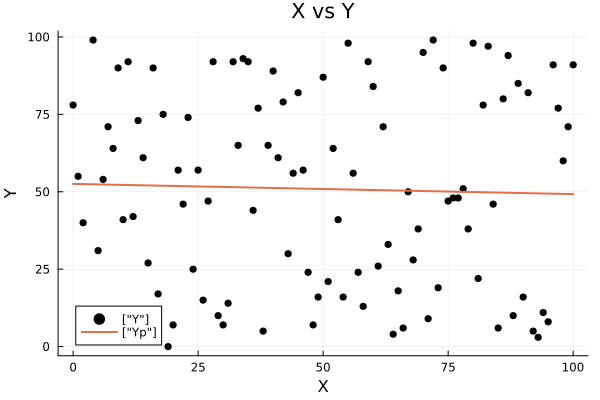

In [12]:
using DataFrames
using BenchmarkTools
using GLM
using Plots

# Generate some random data (four different trials with different size datasets)
data1 = DataFrame(X1=collect(0:100), Y1=rand(0:100,101))
data2 = DataFrame(X2=collect(0:1000), Y2=rand(0:100,1001))
data3 = DataFrame(X3=collect(0:10000), Y3=rand(0:100,10001))
data4 = DataFrame(X4=collect(0:100000), Y4=rand(0:100,100001))

# Perform the ordinary least squares fits
ols1 = @btime lm(@formula(Y1 ~ X1), data1)
ols2 = @btime lm(@formula(Y2 ~ X2), data2)
ols3 = @btime lm(@formula(Y3 ~ X3), data3)
ols4 = @btime lm(@formula(Y4 ~ X4), data4)

# Display the coefficients
println(coef(ols1))

# Load predictions into Yp
Yp = predict(ols1)

# Plot the points
p1 = scatter(data1.X1, data1.Y1, markerstrokewidth = 0, markercolor = :black, label=["Y"])
# add the fit to the plot 
plot!(p1, data1.X1, Yp, linewidth=2, title="X vs Y", label=["Yp"], xlabel="X", ylabel="Y")


# Linear Regression - Python
(swap to Python kernel)

In [1]:
import statsmodels.api as sm
import numpy as np
import time

# defining the variables
x1 = list(range(101))
x2 = list(range(1001))
x3 = list(range(10001))
x4 = list(range(100001))
y1 = np.random.uniform(low=0, high=100, size=(101,))
y2 = np.random.uniform(low=0, high=100, size=(1001,))
y3 = np.random.uniform(low=0, high=100, size=(10001,))
y4 = np.random.uniform(low=0, high=100, size=(100001,))

# performing the regression
# and fitting the model
starttime = time.perf_counter()
result = sm.OLS(y1, x1).fit()
endtime = time.perf_counter()
elapsed = endtime - starttime
print(f'Time taken trail 1: {elapsed/10E-6} microseconds')

starttime = time.perf_counter()
result = sm.OLS(y2, x2).fit()
endtime = time.perf_counter()
elapsed = endtime - starttime
print(f'Time taken trail 2: {elapsed/10E-6} microseconds')

starttime = time.perf_counter()
result = sm.OLS(y3, x3).fit()
endtime = time.perf_counter()
elapsed = endtime - starttime
print(f'Time taken trial 3: {elapsed/10E-6} microseconds')

starttime = time.perf_counter()
result = sm.OLS(y4, x4).fit()
endtime = time.perf_counter()
elapsed = endtime - starttime
print(f'Time taken trial 4: {elapsed/10E-6} microseconds')

# printing the summary table
print(result.summary())

Time taken: 13071.439508348702 microseconds
Time taken: 158.8171347975731 microseconds
Time taken: 345.4945981502533 microseconds
Time taken: 1846.223324537277 microseconds
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.563
Model:                            OLS   Adj. R-squared (uncentered):              0.563
Method:                 Least Squares   F-statistic:                          1.288e+05
Date:                Fri, 14 Nov 2025   Prob (F-statistic):                        0.00
Time:                        16:19:43   Log-Likelihood:                     -5.0628e+05
No. Observations:              100001   AIC:                                  1.013e+06
Df Residuals:                  100000   BIC:                                  1.013e+06
Df Model:                           1                                                  
Covariance Type:            nonrobu

# DataFrames - julia

(swap to julia kernel)

The datasets are available here:\
https://datasets.imdbws.com/

Metadata is available here:\
https://developer.imdb.com/non-commercial-datasets/#namebasicstsvgz

You can download them using the command `wget <URL_OF_DATASET>`\
And extract the `.tsv` files using the command `gunzip <COMPRESSED_FILE_NAME>`

We will load in and merge these datasets.

Here are the column names and small subsets of datasets `name.basics.tsv`, `title.basics.tsv`, and `title.crew.tsv`:

`title.basics.tsv`
```
tconst	titleType	primaryTitle	originalTitle	isAdult	startYear	endYear	runtimeMinutes	genres
tt0000003	short	Poor Pierrot	Pauvre Pierrot	0	1892	\N	5	Animation,Comedy,Romance
tt0000005	short	Blacksmith Scene	Blacksmith Scene	0	1893	\N	1	Short
tt0000009	movie	Miss Jerry	Miss Jerry	0	1894	\N	45	Romance
```

`title.crew.tsv`

```
tconst	directors	writers
tt0000003	nm0721526	nm0721526
tt0000005	nm0005690	\N
tt0000009	nm0085156	nm0085156
```

`name.basics.tsv`
```
nconst	primaryName	birthYear	deathYear	primaryProfession	knownForTitles
nm0000003	Brigitte Bardot	1934	\N	actress,music_department,producer	tt0057345,tt0049189,tt0056404,tt0054452
nm0000004	John Belushi	1949	1982	actor,writer,music_department	tt0072562,tt0077975,tt0080455,tt0078723
nm0000007	Humphrey Bogart	1899	1957	actor,producer,miscellaneous	tt0034583,tt0043265,tt0037382,tt0042593
nm0000008	Marlon Brando	1924	2004	actor,director,writer	tt0078788,tt0068646,tt0047296,tt0070849
```



In [2]:
# location of dataset 
data_dir="/projects/a9009/tdm5510/workshops/julia_workshops/datasets_2025/"

"/projects/a9009/tdm5510/workshops/julia_workshops/datasets_2025/"

In [3]:
using CSV
using DataFrames

# Load TSV file into a DataFrame
# * is the string concatenation operator in julia, not + as it is in Python 
# missingstring will convert occurances of "\\N" to "missing"
# use the first 10k rows 
@time title_basics = CSV.read(data_dir * "title.basics.tsv", DataFrame; delim='\t', missingstring="\\N", limit=100000, silencewarnings=true)
@time title_crew = CSV.read(data_dir * "title.crew.tsv", DataFrame; delim='\t', missingstring="\\N", limit=100000, silencewarnings=true)
@time name_basics = CSV.read(data_dir * "name.basics.tsv", DataFrame; delim='\t', missingstring="\\N", limit=100000, silencewarnings=true)

# Preview the first few rows
display(first(title_basics, 5))
display(first(title_crew, 5))
display(first(name_basics, 5))

  4.690777 seconds (6.54 M allocations: 365.737 MiB, 9.26% gc time, 97.28% compilation time: 11% of which was recompilation)
  0.180715 seconds (499.43 k allocations: 29.657 MiB, 8.28% gc time, 61.48% compilation time)
  0.095258 seconds (397.75 k allocations: 27.539 MiB, 5.54% compilation time)


Row,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
,String15,String15,String,String,Int64,Int64?,Int64?,Int64?,String31?
1,tt0000001,short,Carmencita,Carmencita,0,1894,missing,1,"Documentary,Short"
2,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,missing,5,"Animation,Short"
3,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892,missing,5,"Animation,Comedy,Romance"
4,tt0000004,short,Un bon bock,Un bon bock,0,1892,missing,12,"Animation,Short"
5,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,missing,1,Short


Row,tconst,directors,writers
,String15,String?,String?
1,tt0000001,nm0005690,missing
2,tt0000002,nm0721526,missing
3,tt0000003,nm0721526,nm0721526
4,tt0000004,nm0721526,missing
5,tt0000005,nm0005690,missing


Row,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
,String15,String,Int64?,Int64?,String?,String?
1,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0072308,tt0050419,tt0027125,tt0025164"
2,nm0000002,Lauren Bacall,1924,2014,"actress,miscellaneous,soundtrack","tt0037382,tt0075213,tt0038355,tt0117057"
3,nm0000003,Brigitte Bardot,1934,missing,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"
4,nm0000004,John Belushi,1949,1982,"actor,writer,music_department","tt0072562,tt0077975,tt0080455,tt0078723"
5,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0050976,tt0083922"


In [4]:
# Join title.basics and title.crew on the movie identifier strings (tconst)
# We'll use left join to keep all of the rows from title.basics plus tconst matches from title.crew

# Note that some of these join operations may fail if more rows are used 
# That have misformatted data which would require more careful cleaning

# Ensure tconst is String
title_basics.tconst = replace.(String.(title_basics.tconst))
title_crew.tconst   = replace.(String.(title_crew.tconst))

# Drop missing values if any
dropmissing!(title_basics, :tconst)
dropmissing!(title_crew, :tconst)

# Perform join
@time joined_basics_crew = leftjoin(title_basics, title_crew, on = :tconst)

first(joined_basics_crew, 5)


  2.800586 seconds (3.19 M allocations: 172.909 MiB, 1.15% gc time, 99.56% compilation time)


Row,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,directors,writers
,String,String15,String,String,Int64,Int64?,Int64?,Int64?,String31?,String?,String?
1,tt0000001,short,Carmencita,Carmencita,0,1894,missing,1,"Documentary,Short",nm0005690,missing
2,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,missing,5,"Animation,Short",nm0721526,missing
3,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892,missing,5,"Animation,Comedy,Romance",nm0721526,nm0721526
4,tt0000004,short,Un bon bock,Un bon bock,0,1892,missing,12,"Animation,Short",nm0721526,missing
5,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,missing,1,Short,nm0005690,missing


In [5]:
# Join joined_basics_crew and name.basics on the directors name identifier strings 
# this is directors in joined_basics_crew and nconst in name.basics
# We'll use left join to keep all of the rows from 
# joined_basics_crew plus directors--nconst matches from name.basics

# Drop missing values if any
dropmissing!(joined_basics_crew, :directors)
dropmissing!(name_basics, :nconst)

# Ensure directors and nconst are String
joined_basics_crew.directors = replace.(String.(joined_basics_crew.directors))
name_basics.nconst   = replace.(String.(name_basics.nconst))

# Perform join
@time joined_basics_crew_names = leftjoin(joined_basics_crew, name_basics, on = [:directors => :nconst])

first(joined_basics_crew_names, 5)


  1.251532 seconds (1.14 M allocations: 83.031 MiB, 1.57% gc time, 96.50% compilation time)


Row,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,directors,writers,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
,String,String15,String,String,Int64,Int64?,Int64?,Int64?,String31?,String,String?,String?,Int64?,Int64?,String?,String?
1,tt0038468,movie,It Rains on Our Love,Det regnar på vår kärlek,0,1946,missing,95,"Drama,Romance",nm0000005,"nm0102602,nm0340471,nm0000005",Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0050976,tt0083922"
2,tt0038675,movie,Crisis,Kris,0,1946,missing,93,"Drama,Romance",nm0000005,"nm0000005,nm0279027",Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0050976,tt0083922"
3,tt0039834,movie,A Ship to India,Skepp till India land,0,1947,missing,98,Drama,nm0000005,"nm0000005,nm0845496",Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0050976,tt0083922"
4,tt0040418,movie,Port of Call,Hamnstad,0,1948,missing,100,Drama,nm0000005,"nm0000005,nm0529508",Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0050976,tt0083922"
5,tt0040622,movie,Music in Darkness,Musik i mörker,0,1948,missing,87,Drama,nm0000005,nm0249647,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0050976,tt0083922"


In [6]:
# Select all rows where startYear is 1970

dropmissing!(joined_basics_crew_names, :startYear)
start_1970 = joined_basics_crew_names[joined_basics_crew_names.startYear .== 1970, :]
first(start_1970, 5)



Row,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,directors,writers,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
,String,String15,String,String,Int64,Int64,Int64?,Int64?,String31?,String,String?,String?,Int64?,Int64?,String?,String?
1,tt0064355,tvMovie,Faro Document,Fårö dokument,0,1970,missing,57,Documentary,nm0000005,missing,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0050976,tt0083922"
2,tt0066922,tvMovie,The Clowns,I clowns,0,1970,missing,92,Comedy,nm0000019,"nm0000019,nm0953301",Federico Fellini,1920,1993,"writer,director,actor","tt0056801,tt0053779,tt0050783,tt0071129"
3,tt0065542,movie,The Cheyenne Social Club,The Cheyenne Social Club,0,1970,missing,103,"Comedy,Western",nm0000037,"nm0057157,nm0344181",Gene Kelly,1912,1996,"actor,miscellaneous,director","tt0045152,tt0043278,tt0041716,tt0053946"
4,tt0065649,movie,Dodes'ka-den,Dodesukaden,0,1970,missing,140,Drama,nm0000041,"nm0000041,nm0644823,nm0368074,nm0945491",Akira Kurosawa,1910,1998,"writer,director,assistant_director","tt0089881,tt0080979,tt0051808,tt0057565"
5,tt0064285,movie,The Wild Child,L'enfant sauvage,0,1970,missing,83,"Biography,Drama,History",nm0000076,"nm0000076,nm0344171,nm0411639",François Truffaut,1932,1984,"writer,director,producer","tt0070460,tt0075860,tt0053198,tt0055032"


In [10]:
# See information about just movie with tconst is tt0066922

dropmissing!(joined_basics_crew_names, :tconst)
one_movie = joined_basics_crew_names[joined_basics_crew_names.tconst .== "tt0066922", :]
first(one_movie, 1)


Row,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,directors,writers,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
,String,String15,String,String,Int64,Int64,Int64?,Int64?,String31?,String,String?,String?,Int64?,Int64?,String?,String?
1,tt0066922,tvMovie,The Clowns,I clowns,0,1970,missing,92,Comedy,nm0000019,"nm0000019,nm0953301",Federico Fellini,1920,1993,"writer,director,actor","tt0056801,tt0053779,tt0050783,tt0071129"


## DataFrames -- Python

Do the same operations as above, but in python\
(swap to python kernel)

In [1]:
# Location of dataset
data_dir = "/projects/a9009/tdm5510/workshops/julia_workshops/datasets_2025/"

In [2]:
import pandas as pd
import time

# Load TSV files into DataFrames
# Convert "\\N" to NaN using na_values
# Limit to first 100,000 rows

start_time = time.time()
title_basics = pd.read_csv(f"{data_dir}title.basics.tsv", sep='\t', na_values="\\N", nrows=100000)
print(f"Loaded title_basics in {time.time() - start_time:.2f}s")

start_time = time.time()
title_crew = pd.read_csv(f"{data_dir}title.crew.tsv", sep='\t', na_values="\\N", nrows=100000)
print(f"Loaded title_crew in {time.time() - start_time:.2f}s")

start_time = time.time()
name_basics = pd.read_csv(f"{data_dir}name.basics.tsv", sep='\t', na_values="\\N", nrows=100000)
print(f"Loaded name_basics in {time.time() - start_time:.2f}s")

# Preview first few rows
print(title_basics.head())
print(title_crew.head())
print(name_basics.head())

Loaded title_basics in 0.28s
Loaded title_crew in 0.14s
Loaded name_basics in 0.24s
      tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short            Poor Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

   isAdult  startYear  endYear  runtimeMinutes                    genres  
0        0     1894.0      NaN             1.0         Documentary,Short  
1        0     1892.0      NaN             5.0           Animation,Short  
2        0     1892.0      NaN             5.0  Animation,Comedy,Romance  
3        0     1892.0      NaN            12.0           Animation,Short  
4        0     1893.0      NaN             1.0                     Short  
      tconst  directo

In [3]:
# Ensure tconst is string and drop missing values
title_basics['tconst'] = title_basics['tconst'].astype(str)
title_crew['tconst'] = title_crew['tconst'].astype(str)

title_basics = title_basics.dropna(subset=['tconst'])
title_crew = title_crew.dropna(subset=['tconst'])

# Perform left join on tconst
start_time = time.time()
joined_basics_crew = pd.merge(title_basics, title_crew, on='tconst', how='left')
print(f"Joined basics and crew in {time.time() - start_time:.2f}s")

print(joined_basics_crew.head())

Joined basics and crew in 0.02s
      tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short            Poor Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

   isAdult  startYear  endYear  runtimeMinutes                    genres  \
0        0     1894.0      NaN             1.0         Documentary,Short   
1        0     1892.0      NaN             5.0           Animation,Short   
2        0     1892.0      NaN             5.0  Animation,Comedy,Romance   
3        0     1892.0      NaN            12.0           Animation,Short   
4        0     1893.0      NaN             1.0                     Short   

   directors    writers  
0  nm0005690        NaN  
1  nm0721526  

In [4]:
# Drop missing directors and nconst
joined_basics_crew = joined_basics_crew.dropna(subset=['directors'])
name_basics = name_basics.dropna(subset=['nconst'])

# Ensure directors and nconst are strings
joined_basics_crew['directors'] = joined_basics_crew['directors'].astype(str)
name_basics['nconst'] = name_basics['nconst'].astype(str)

# Perform left join on directors -> nconst
start_time = time.time()
joined_basics_crew_names = pd.merge(joined_basics_crew, name_basics, left_on='directors', right_on='nconst', how='left')
print(f"Joined basics_crew and names in {time.time() - start_time:.2f}s")

print(joined_basics_crew_names.head())

Joined basics_crew and names in 0.10s
      tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short            Poor Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

   isAdult  startYear  endYear  runtimeMinutes                    genres  \
0        0     1894.0      NaN             1.0         Documentary,Short   
1        0     1892.0      NaN             5.0           Animation,Short   
2        0     1892.0      NaN             5.0  Animation,Comedy,Romance   
3        0     1892.0      NaN            12.0           Animation,Short   
4        0     1893.0      NaN             1.0                     Short   

   directors    writers     nconst           primaryName  bi

In [5]:
# Select rows where startYear == 1970
joined_basics_crew_names = joined_basics_crew_names.dropna(subset=['startYear'])
start_1970 = joined_basics_crew_names[joined_basics_crew_names['startYear'] == 1970]

print(start_1970.head())


          tconst  titleType                  primaryTitle  \
29472  tt0031458  tvEpisode      El huésped del sevillano   
56295  tt0059375    tvMovie           Házasodj, Ausztria!   
56588  tt0059680      movie               Satan's Harvest   
57335  tt0060462      movie  The Girls from Thunder Strip   
57349  tt0060477      movie        Gregorio and His Angel   

                      originalTitle  isAdult  startYear  endYear  \
29472      El huésped del sevillano        0     1970.0      NaN   
56295           Házasodj, Ausztria!        0     1970.0      NaN   
56588               Satan's Harvest        0     1970.0      NaN   
57335  The Girls from Thunder Strip        0     1970.0      NaN   
57349           Gregorio y su ángel        0     1970.0      NaN   

       runtimeMinutes                genres  directors  \
29472            86.0               Musical  nm0649563   
56295            75.0        Comedy,Musical  nm0395825   
56588            88.0                Action  nm059

In [6]:
# Drop rows where tconst is missing
joined_basics_crew_names = joined_basics_crew_names.dropna(subset=['tconst'])

# Filter for the movie with tconst == "tt0066922"
one_movie = joined_basics_crew_names[joined_basics_crew_names['tconst'] == "tt0066922"]

# Show the first row
print(one_movie.head(1))


          tconst titleType primaryTitle originalTitle  isAdult  startYear  \
63527  tt0066922   tvMovie   The Clowns      I clowns        0     1970.0   

       endYear  runtimeMinutes  genres  directors              writers  \
63527      NaN            92.0  Comedy  nm0000019  nm0000019,nm0953301   

          nconst       primaryName  birthYear  deathYear  \
63527  nm0000019  Federico Fellini     1920.0     1993.0   

           primaryProfession                           knownForTitles  
63527  writer,director,actor  tt0056801,tt0053779,tt0050783,tt0071129  
